<a href="https://colab.research.google.com/github/lekhanas6/Stock_Optimization/blob/main/BDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project: ‘Stocks’ OPIM 5641

##Group - 3

* Brittany
* Geetha
* Lekhana
* Likhila
* Sourya


### Importing required modules and stock-specific Packages


In [ ]:
# some useful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns

In [ ]:
# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Installing pyomo for the IPOPT solver


In [ ]:
# install pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' # THIS IS NEW! We are using the IPOPT Solver.
except:
    pass


In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

##Preparing the Data & Exploratory Data Analysis

### To investigate investment strategies for stocks based on Modern Portfolio Theory and Momentum Trading, we selected three stocks under three different sectors(9 stocks in total) daily data with at least five years worth of data.

# Stock Selection:


### Real Estate Stocks:

 + Boston Properties, Inc. (BXP)

   +   https://finance.yahoo.com/quote/BXP


+ Invitation Homes Inc. (INVH)

  + https://finance.yahoo.com/quote/INVH

+ Kimco Realty Corporation (KIM)

  + https://finance.yahoo.com/quote/KIM

### Utilities Stocks:

+ The AES Corporation (AES)

  + https://finance.yahoo.com/quote/AES

+ PG&E Corporation (PCG)

  + https://finance.yahoo.com/quote/PCG

+ Dominion Energy, Inc. (D)

  + https://finance.yahoo.com/quote/D

### Consumer Staples Stocks:

+ The Coca-Cola Company (KO)

  + https://finance.yahoo.com/quote/KO

+ Keurig Dr Pepper Inc. (KDP)

  + https://finance.yahoo.com/quote/KDP

+ PepsiCo, Inc. (PEP)

  + https://finance.yahoo.com/quote/PEP

## Data processing and visualizing
We combined all the data into a single dataframe as part of the data cleaning process, and we eliminated all **NAN** values. Then, using time-series visualizations, we examined data for various sectors' performance over time, downloading historical stock data for modeling from January 2017 to December 2021. Once constructed, this model will aid in the analysis of the portfolio at various risk levels. As a result, we test this portfolio allocation model for a variety of risk ceilings that were specified as requirements when developing the model.

In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['BXP','INVH','KIM','AES','PCG','D','KO','KDP','PEP']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='01/01/2022',interval='1d') for ticker in tickers_list}

In [ ]:
# take a peak!
dow_prices

{'BXP':                   open        high         low       close    adjclose  \
 2017-01-03  127.699997  127.930000  125.989998  127.180000  104.845207   
 2017-01-04  127.660004  131.610001  127.220001  131.220001  108.175720   
 2017-01-05  130.199997  132.550003  128.759995  131.850006  108.695107   
 2017-01-06  131.589996  132.509995  131.210007  131.550003  108.447769   
 2017-01-09  131.059998  131.399994  129.960007  130.240005  107.367836   
 ...                ...         ...         ...         ...         ...   
 2021-12-27  114.260002  115.940002  113.430000  115.900002  111.398758   
 2021-12-28  115.370003  116.279999  114.510002  115.309998  110.831665   
 2021-12-29  115.669998  115.919998  114.089996  115.580002  111.091194   
 2021-12-30  115.000000  116.760002  114.870003  115.720001  112.176903   
 2021-12-31  115.580002  116.440002  115.169998  115.180000  111.653435   
 
              volume ticker  
 2017-01-03   813900    BXP  
 2017-01-04  1323500    BXP  
 

In [ ]:
print(dow_prices.keys())

dict_keys(['BXP', 'INVH', 'KIM', 'AES', 'PCG', 'D', 'KO', 'KDP', 'PEP'])


In [ ]:
# extract just the data we need (adjclose)
prep_data = {}
for i in tickers_list:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose']).rename(columns = {"adjclose":i})
  prep_data[i] = prep_data[i].resample('D').max().ffill()  # resample to a 1 day granularity incase some of the days are missing
                                # forward fill the missing values

In [ ]:
# combine all the tickers
df = pd.concat([prep_data[i] for i in tickers_list], axis=1)
df  # since the date range are not consistant, there're many missing values

,BXP,INVH,KIM,AES,PCG,D,KO,KDP,PEP
2017-01-03,104.845207,NaN,18.740808,9.529103,58.993298,59.765762,34.493889,12.955996,87.989281
2017-01-04,108.175720,NaN,19.169081,9.447379,59.208290,59.710899,34.370094,13.017307,88.157448
2017-01-05,108.695107,NaN,19.250311,9.324791,59.159428,59.789268,34.452625,13.028717,88.039726
2017-01-06,108.447769,NaN,19.110012,9.659863,59.823921,60.275242,34.444374,12.965976,87.913628
2017-01-07,108.447769,NaN,19.110012,9.659863,59.823921,60.275242,34.444374,12.965976,87.913628
...,...,...,...,...,...,...,...,...,...
2021-12-27,111.398758,43.475212,23.146507,23.021473,11.910000,74.724129,56.964680,35.367893,167.001892
2021-12-28,110.831665,43.533787,23.213934,23.089554,12.060000,75.187363,57.188076,35.622547,167.868713
2021-12-29,111.091194,44.100048,23.358419,23.128458,11.990000,75.679535,57.256058,35.828232,168.462784
2021-12-30,112.176903,44.090286,23.618494,23.507772,12.070000,75.727791,57.090942,35.926174,168.170609


In [ ]:
 #remove entries of days for which information is missing
df = df.dropna()

In [ ]:
df

,BXP,INVH,KIM,AES,PCG,D,KO,KDP,PEP
2017-02-01,106.568176,17.851709,18.142698,9.283582,59.501446,56.316986,34.048267,12.891829,86.610390
2017-02-02,107.557442,18.057005,18.364222,9.349658,60.537273,56.183746,34.163803,13.058661,87.468002
2017-02-03,107.763527,18.414036,18.349451,9.390955,60.185478,56.199406,34.279331,13.078626,88.376053
2017-02-04,107.763527,18.414036,18.349451,9.390955,60.185478,56.199406,34.279331,13.078626,88.376053
2017-02-05,107.763527,18.414036,18.349451,9.390955,60.185478,56.199406,34.279331,13.078626,88.376053
...,...,...,...,...,...,...,...,...,...
2021-12-27,111.398758,43.475212,23.146507,23.021473,11.910000,74.724129,56.964680,35.367893,167.001892
2021-12-28,110.831665,43.533787,23.213934,23.089554,12.060000,75.187363,57.188076,35.622547,167.868713
2021-12-29,111.091194,44.100048,23.358419,23.128458,11.990000,75.679535,57.256058,35.828232,168.462784
2021-12-30,112.176903,44.090286,23.618494,23.507772,12.070000,75.727791,57.090942,35.926174,168.170609


Rather than use the raw time series, let's build a model based on past returns (the difference from the previous day).

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
df = pd.DataFrame()
for i in tickers_list:
  df[i] = prep_data[i].pct_change()
# drop the na records
df.dropna(inplace=True)
df

,BXP,INVH,KIM,AES,PCG,D,KO,KDP,PEP
2017-02-02,0.009283,0.011500,0.012210,0.007118,0.017408,-0.002366,0.003393,0.012941,0.009902
2017-02-03,0.001916,0.019772,-0.000804,0.004417,-0.005811,0.000279,0.003382,0.001529,0.010382
2017-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-06,0.004590,0.004847,-0.003622,-0.007036,0.000650,0.007113,0.000481,-0.005887,-0.005138
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.014353,0.013197,0.014352,0.005096,-0.007500,0.001164,0.007386,0.004730,0.009954
2021-12-28,-0.005091,0.001347,0.002913,0.002957,0.012595,0.006199,0.003922,0.007200,0.005190
2021-12-29,0.002342,0.013007,0.006224,0.001685,-0.005804,0.006546,0.001189,0.005774,0.003539
2021-12-30,0.009773,-0.000221,0.011134,0.016400,0.006672,0.000638,-0.002884,0.002734,-0.001734


## Visualize the Time Series

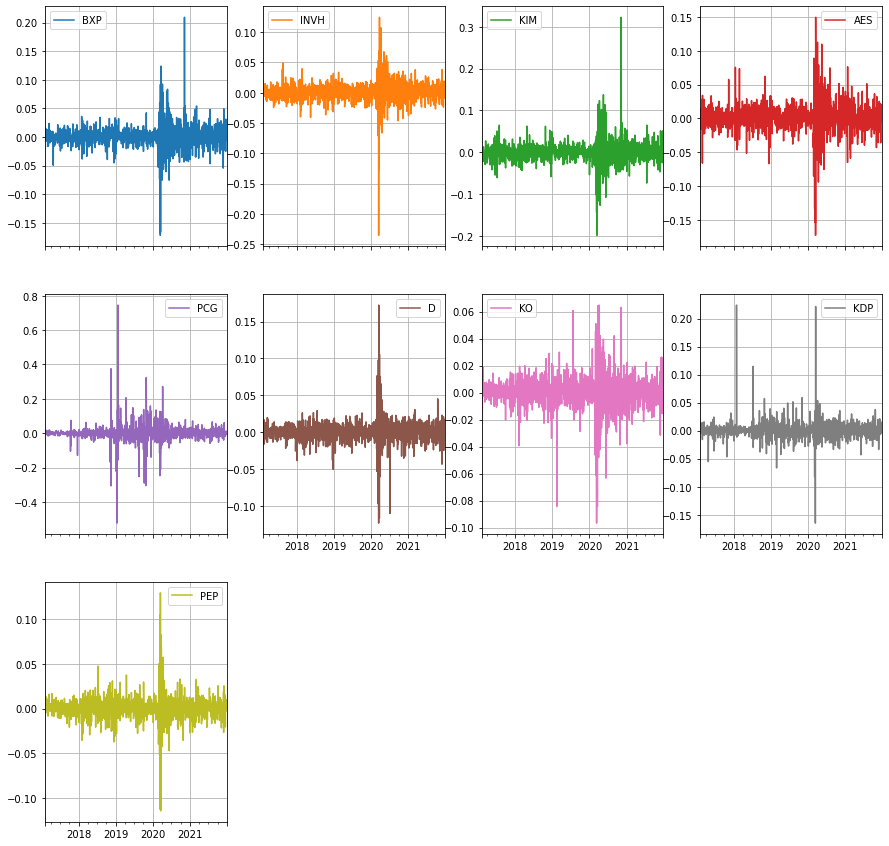

In [ ]:
df.plot(subplots=True,
        grid=True,
        layout=(3,4),
         figsize=(15,15))

plt.show()

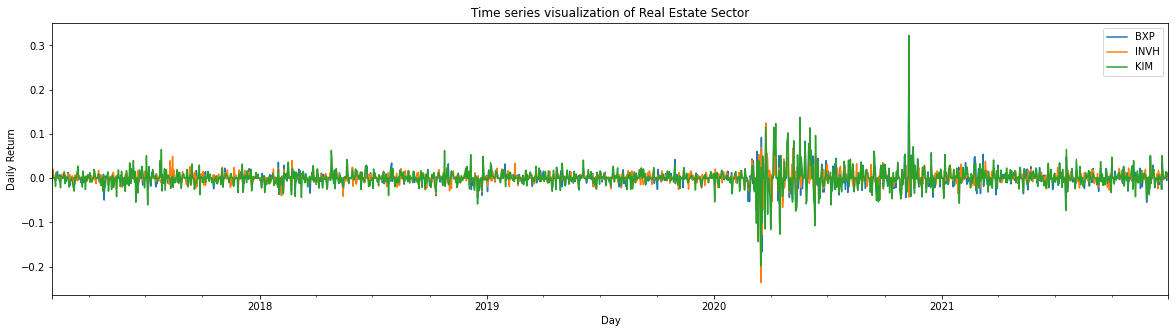

In [ ]:
a=df[['BXP','INVH','KIM']]
a.plot(figsize=(20,5))
plt.title('Time series visualization of Real Estate Sector')
#labels x and y on graph
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()



Volatility remains constant but varies during first half of 2020, specially the KIM stocks


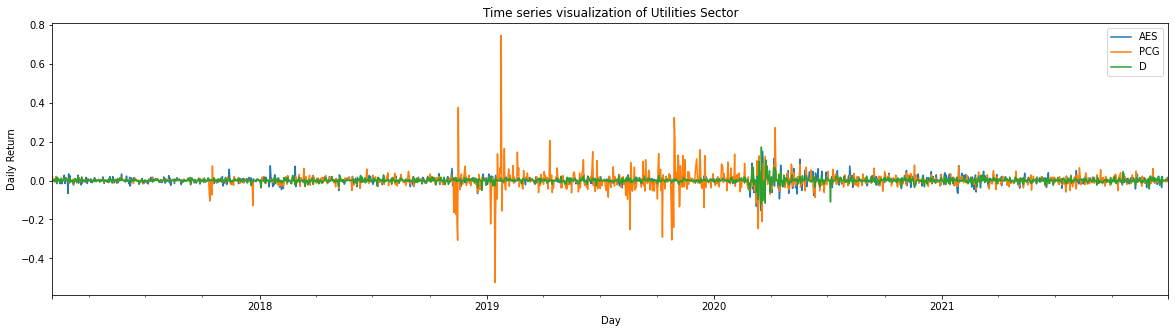

In [ ]:
b=df[['AES','PCG','D']]
b.plot(figsize=(20,5))
plt.title('Time series visualization of Utilities Sector')
#labels x and y on graph
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()


Volatility is almost constant for the 2 stocks that is AES and D. The PCG volatility fluctuates a lot during 2019 whereas D stocks volatility varies during first half of 2020

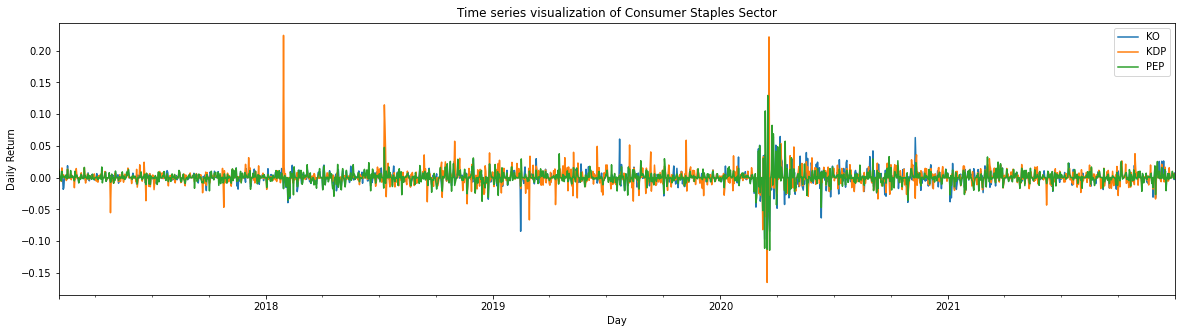

In [ ]:
c=df[['KO','KDP','PEP']]
c.plot(figsize=(20,5))
plt.title('Time series visualization of Consumer Staples Sector')
#labels x and y on graph
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()

KO shows low volatility whereas PEP shows high volatility. PEP fluctuates a lot during 2020 and KDP also displays random fluctuations.

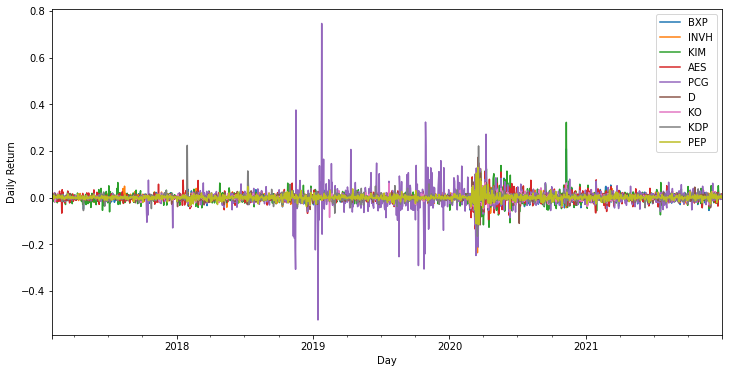

In [ ]:
# see what it looks like... messy... some volatility here!
df.plot()
#labels x and y on graph
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.rcParams['figure.figsize'] = (20,5)
plt.show()
# get rid of funky text


## Explanation & Discussion of data and EDA

**Real Estate Sector:**
In the time series visualizations made for real estate sector, it can be observed that, the volatality of all 3 stocks remain constant from 2017 to 2020. But a significant variation can be seen in the year 2020. Kimco Realty Corporation (KIM) seem to have had more impact compared to the other two stocks.

**Utilities Stock**
In the time series visualizations made for Utilities sector, it can be observed that the volatility of the 2 stocks like AES and D are maintained constant with a little variation of D during first half of 2020. The PCG volatility is high as it fluctuates a lot during the year 2019.

**Consumer Staples Stock**
In the time series visualizations made for Utilities sector, it can be observed that KO shows low volatility as it is maintained constant overall whereas PEP shows high volatility. PEP fluctuates a lot during 2020 and KDP also displays random fluctuations.

**The possible reason for a lot of fluctuation during 2020 could be due to COVID-19 pandemic. As COVID-19 spread across the world with unprecedented speed, consumer and investor behavior dramatically shifted.**




# **Modern Portfolio Theory**

We wish to combine the stocks we've chosen above to create a portfolio. But first, we must build a variety of portfolios with various volatiles, then choose the portfolio with the highest return at a particular risk level. We first specify the ConcreteModel before developing the Optimization model. The decision variables are then defined and bound (between 0 and 1), which is crucial for a nonlinear solver. Adding restrictions such as the maximum risk (no bound), and the sum of proportions (which must equal 1) .

To determine which assets to include in the portfolio, we first calculated the covariance. The next step in balancing our portfolio is to examine the differences between the stocks in it.

The stocks in the portfolio contribute a lesser percentage of returns on a daily basis as the models are iterated for different return values.

In [ ]:
# helpful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
# import datetime # handling dates
# import time # handling times
# from dateutil.relativedelta import relativedelta # time difference
# from matplotlib.pyplot import figure

In [ ]:
# we need to mount our drive since we are linking to a spreadsheet on our drive!
# copy and paste the code, then enter!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install pyomo
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
ipopt_executable='/content/ipopt'

In [ ]:
#shows average return of each stock
Avg_Return = pd.DataFrame(np.mean(df) ,columns=["Avg_Return"])
print(Avg_Return)
#shows standard deviation of each stock
Std_Dev_Return = pd.DataFrame(np.std(df) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
BXP     0.000165
INVH    0.000609
KIM     0.000382
AES     0.000682
PCG     0.000015
D       0.000250
KO      0.000349
KDP     0.000668
PEP     0.000434
      Std_Dev_Return
BXP         0.016644
INVH        0.014106
KIM         0.021661
AES         0.017829
PCG         0.042138
D           0.012958
KO          0.010600
KDP         0.013889
PEP         0.011003


## **Covariance and MPT**

In [ ]:
#covariance matrix
Covariance_matrix = df.cov()
Covariance_matrix

,BXP,INVH,KIM,AES,PCG,D,KO,KDP,PEP
BXP,0.000277,0.000146,0.000279,0.000157,0.000154,0.000101,0.000103,0.000059,0.000086
INVH,0.000146,0.000199,0.000159,0.000120,0.000114,0.000101,0.000078,0.000057,0.000084
KIM,0.000279,0.000159,0.000469,0.000197,0.000167,0.000102,0.000110,0.000072,0.000075
AES,0.000157,0.000120,0.000197,0.000318,0.000181,0.000091,0.000082,0.000081,0.000076
PCG,0.000154,0.000114,0.000167,0.000181,0.001777,0.000107,0.000090,0.000077,0.000095
D,0.000101,0.000101,0.000102,0.000091,0.000107,0.000168,0.000079,0.000042,0.000092
KO,0.000103,0.000078,0.000110,0.000082,0.000090,0.000079,0.000112,0.000041,0.000085
KDP,0.000059,0.000057,0.000072,0.000081,0.000077,0.000042,0.000041,0.000193,0.000057
PEP,0.000086,0.000084,0.000075,0.000076,0.000095,0.000092,0.000085,0.000057,0.000121


In [ ]:
#correlation matrix
Corr_matrix = df.corr()
Corr_matrix

,BXP,INVH,KIM,AES,PCG,D,KO,KDP,PEP
BXP,1.000000,0.622520,0.772470,0.529891,0.220132,0.466095,0.581699,0.257145,0.469783
INVH,0.622520,1.000000,0.520761,0.475256,0.191803,0.553694,0.518413,0.288460,0.539363
KIM,0.772470,0.520761,1.000000,0.510411,0.182691,0.363654,0.478865,0.238618,0.314914
AES,0.529891,0.475256,0.510411,1.000000,0.240476,0.394432,0.434691,0.328207,0.386211
PCG,0.220132,0.191803,0.182691,0.240476,1.000000,0.196464,0.201851,0.130728,0.204669
D,0.466095,0.553694,0.363654,0.394432,0.196464,1.000000,0.575639,0.235362,0.642756
KO,0.581699,0.518413,0.478865,0.434691,0.201851,0.575639,1.000000,0.278185,0.729947
KDP,0.257145,0.288460,0.238618,0.328207,0.130728,0.235362,0.278185,1.000000,0.370792
PEP,0.469783,0.539363,0.314914,0.386211,0.204669,0.642756,0.729947,0.370792,1.000000


## **Build the Nonlinear Optimization Model**

In [ ]:
# creating covariance table on stock return dataframe
df_cov = df.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = df.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           BXP      INVH       KIM       AES       PCG         D        KO  \
BXP   0.000277  0.000146  0.000279  0.000157  0.000154  0.000101  0.000103   
INVH  0.000146  0.000199  0.000159  0.000120  0.000114  0.000101  0.000078   
KIM   0.000279  0.000159  0.000469  0.000197  0.000167  0.000102  0.000110   
AES   0.000157  0.000120  0.000197  0.000318  0.000181  0.000091  0.000082   
PCG   0.000154  0.000114  0.000167  0.000181  0.001777  0.000107  0.000090   
D     0.000101  0.000101  0.000102  0.000091  0.000107  0.000168  0.000079   
KO    0.000103  0.000078  0.000110  0.000082  0.000090  0.000079  0.000112   
KDP   0.000059  0.000057  0.000072  0.000081  0.000077  0.000042  0.000041   
PEP   0.000086  0.000084  0.000075  0.000076  0.000095  0.000092  0.000085   

           KDP       PEP  
BXP   0.000059  0.000086  
INVH  0.000057  0.000084  
KIM   0.000072  0.000075  
AES   0.000081  0.000076  
PCG   0.000077  0.000095  
D     0.000042  0.000092  
KO    0.000

 ### Variables:

---


* BXP $\in (0,1) $ `proportion of BXP`
* INVH $\in (0,1) $ `proportion of INVH`
* KIM $\in (0,1) $ `proportion of KIM`
*  AES  $\in (0,1) $ `proportion of AES`
*  PCG  $\in (0,1) $ `proportion of PCG`
*  D  $\in (0,1) $ `proportion of D`
*  KO  $\in (0,1) $ `proportion of KO`
*  KDP  $\in (0,1) $ `proportion of KDP`
*  PEP  $\in (0,1) $ `proportion of PEP`

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock
m.BXP = Var(within=NonNegativeReals, bounds=(0,1))
m.INVH = Var(within=NonNegativeReals, bounds=(0,1))
m.KIM = Var(within=NonNegativeReals, bounds=(0,1))
m.AES = Var(within=NonNegativeReals, bounds=(0,1))
m.PCG = Var(within=NonNegativeReals, bounds=(0,1))
m.D = Var(within=NonNegativeReals, bounds=(0,1))
m.KO = Var(within=NonNegativeReals, bounds=(0,1))
m.KDP = Var(within=NonNegativeReals, bounds=(0,1))
m.PEP = Var(within=NonNegativeReals, bounds=(0,1))

We specify the objective function; **maximize your returns** - make as much money as possible! Note how we specify the fraction/proportion we are investing in each stock multiplied by its average return.

We also specify  constraints.

The amount you invest in your portfolio needs to sum to '1' or 100%... you must invest all of your money, regardless of how much money you start with (100K or 100M)

We set the **maximum risk** is 100%

We will try to identify which mix of stocks gives us the max return for a given risk level.



In [ ]:
# declare objective
m.objective = Objective(expr =
                        m.BXP*df_return[0] +
                        m.INVH*df_return[1] +
                        m.KIM*df_return[2] +
                        m.AES*df_return[3] +
                        m.PCG*df_return[4] +
                        m.D*df_return[5] +
                        m.KO*df_return[6] +
                        m.KDP*df_return[7] +
                        m.PEP*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.BXP + m.INVH + m.KIM + m.AES + m.PCG + m.D + m.KO + m.KDP + m.PEP == 1)


# Set maximum risk
m.total_risk = Constraint(expr = m.BXP + m.INVH + m.KIM + m.AES + m.PCG + m.D + m.KO + m.KDP + m.PEP >= 100)


**Calculations of proportions based on the above restrictions and establishing risk ceilings. Lower step size was taken into consideration in order to attain granularity and precision during the creation of an efficient frontier**

In [ ]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = m.BXP, m.INVH, m.KIM, m.AES, m.PCG, m.D, m.KO, m.KDP, m.PEP
  tickers = ['BXP','INVH','KIM','AES','PCG','D','KO','KDP','PEP']
  risk_exp = 0
#create for loops for all of the variables using the covariance in order to compute the risk
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk
max_risk = 0.0002
# Sequence of risk levels
risk_limits = np.arange(0.00005, max_risk, 0.000005) # take tiny steps
risk_limits

array([5.00e-05, 5.50e-05, 6.00e-05, 6.50e-05, 7.00e-05, 7.50e-05,
       8.00e-05, 8.50e-05, 9.00e-05, 9.50e-05, 1.00e-04, 1.05e-04,
       1.10e-04, 1.15e-04, 1.20e-04, 1.25e-04, 1.30e-04, 1.35e-04,
       1.40e-04, 1.45e-04, 1.50e-04, 1.55e-04, 1.60e-04, 1.65e-04,
       1.70e-04, 1.75e-04, 1.80e-04, 1.85e-04, 1.90e-04, 1.95e-04])

## **Run Model**
**Now it's time to run the model!All the proportions for each risk levels are stored in the param_analysis. These values are further used to calculate the risk level while using the covariance values from the matrix above.**

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
   #Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue

  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.BXP(), m.INVH(), m.KIM(), m.AES(), m.PCG(), m.D(), m.KO(), m.KDP(), m.PEP()]
  # store our returns
  returns[r] =  m.BXP()*df_return[0] + m.INVH()*df_return[1] + m.KIM()*df_return[2] + m.AES()*df_return[3] + m.PCG()*df_return[4] + m.D()*df_return[5] + m.KO()*df_return[6] + m.KDP()*df_return[7] + m.PEP()*df_return[8]


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 9.800948858261108
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of sol

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 8.839974880218506
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of sol

## **Parameter Analysis**

**The individual stocks allocation for the nine stocks at various risk levels is shown on a graph that shows risk and return/reward. Using this graph reference as to filter these stocks with increasing returns at that specific risk level identified from the efficient frontier below. Let's see how efficient frontier and allocation looks like.**

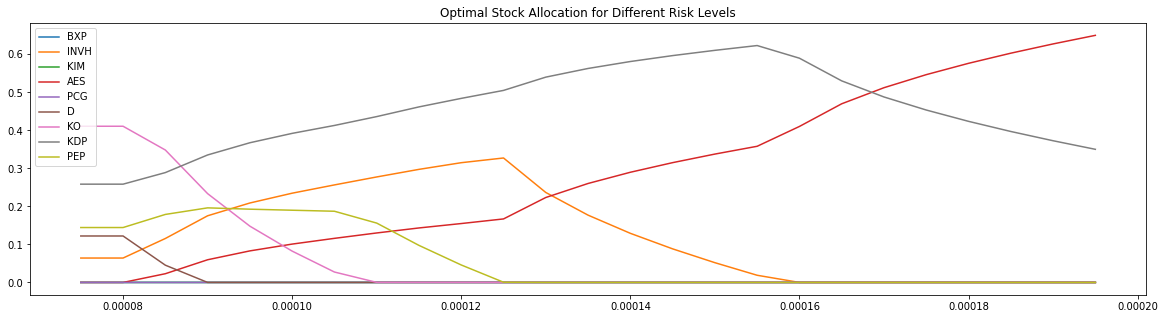

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['BXP','INVH','KIM','AES','PCG','D','KO','KDP','PEP']
param_analysis.plot(figsize = (20,5))
#Creates plot title and then shows plot
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

**On the left hand side, we have low risk and high diversity. On the right hand side, we have high risk and low diversity.**

**Efficient Frontier**

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[7.500000000000001e-05, 7.999999999999999e-05, 8.5e-05, 8.999999999999999e-05, 9.5e-05, 9.999999999999999e-05, 0.000105, 0.00010999999999999999, 0.000115, 0.00011999999999999999, 0.000125, 0.00013, 0.000135, 0.00014, 0.000145, 0.00015, 0.000155, 0.00015999999999999999, 0.000165, 0.00016999999999999999, 0.000175, 0.00017999999999999998, 0.00018499999999999997, 0.00018999999999999998, 0.000195]
[0.0004481386003873998, 0.00044813860082820414, 0.0004893982212122981, 0.0005378934750517108, 0.0005643545756472329, 0.0005846348976360527, 0.0006017366828790936, 0.000616676677338837, 0.0006293908762130055, 0.0006405626364313908, 0.0006506444348078021, 0.0006569446683718465, 0.0006610074854421022, 0.0006642360717637407, 0.0006670123272764282, 0.0006694825108982794, 0.0006717304745311775, 0.0006735925609680154, 0.0006744242059612284, 0.0006750176161410907, 0.0006755017453183909, 0.0006759214257105618, 0.0006762970947650073, 0.0006766402442555293, 0.0006769580989148483]


##Calculating returns from portfolio

In [ ]:
print("Returns from the portfolio at a risk of 0.00014 = ", round(returns[0.00014]*100,2),"%")

Returns from the portfolio at a risk of 0.00014 =  0.07 %


In [ ]:
allocations = pd.DataFrame(round(param_analysis.loc[0.00014],2))
allocations.rename(columns = {0.00014:"Allocation"}, inplace=True)

print("The Final Allocations are as follows")
allocations

The Final Allocations are as follows


,Allocation
BXP,0.00
INVH,0.13
KIM,0.00
AES,0.29
PCG,0.00
D,0.00
KO,0.00
KDP,0.58
PEP,0.00


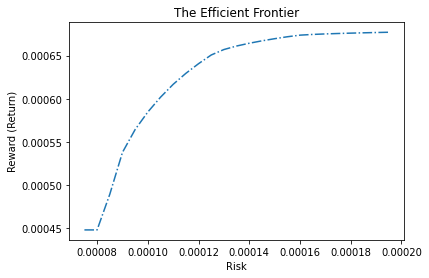

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
#label x and y axis
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

**The risk versus reward graph above shows the portfolio's top 9 stocks. According to the efficient frontier, a return of 0.00067% is attained at a risk of 0.00015, and thereafter, no risk will result in a higher return . It's a good idea to think about the point where the return reaches its maximum and does not alter any more, even though it depends on the investor's risk tolerance! As a result, our team has chosen to work with a risk level of 0.00015 for the evaluation of the data under consideration.**

# **Momentum Trading**

In [ ]:
# you may need to restart your runtime
# https://stackoverflow.com/questions/68230237/python-pandas-datareader-and-yahoo-error-remotedataerror-unable-to-read-url
!pip3 install --upgrade pandas
!pip3 install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

###**Retrieve stock from Yahoo**

In [ ]:
#The 3 stocks for which we want to get data
stocks = ['AES','INVH','KDP']

stock_data = pd.DataFrame()
# Create a concatenated dataframe with stock data for all 3 above stocks
for stock in stocks:
    #Get data for each stock from Jan 1, 2017 to Dec 31, 2021
    df = pdr.get_data_yahoo(stock, start=datetime(2017, 1, 1), end=datetime(2021, 12, 31)).reset_index()[['Date', 'Close']]
    #We extract only Date and Close values of each stock

    #Rename the close column to the stock name so we can merge the data
    df.rename(columns={'Close' : stock}, inplace=True)

    if stock_data.shape[0] == 0:
        stock_data = df
    else:
        stock_data = stock_data.merge(df, on='Date')

#Add a column to signify the trading day
stock_data['Day'] = np.arange(1, len(stock_data) + 1)
stock_data = stock_data[['Date', 'Day'] + stocks]
stock_data.head()

,Date,Day,AES,INVH,KDP
0,2017-02-01,1,11.24,20.000000,90.410004
1,2017-02-02,2,11.32,20.230000,91.580002
2,2017-02-03,3,11.37,20.629999,91.720001
3,2017-02-06,4,11.29,20.730000,91.180000
4,2017-02-07,5,11.43,20.799999,92.580002


In [ ]:
# Check if our data has null values
stock_data.isnull().sum()

Date    0
Day     0
AES     0
INVH    0
KDP     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd501eed00>,
      dtype=object)

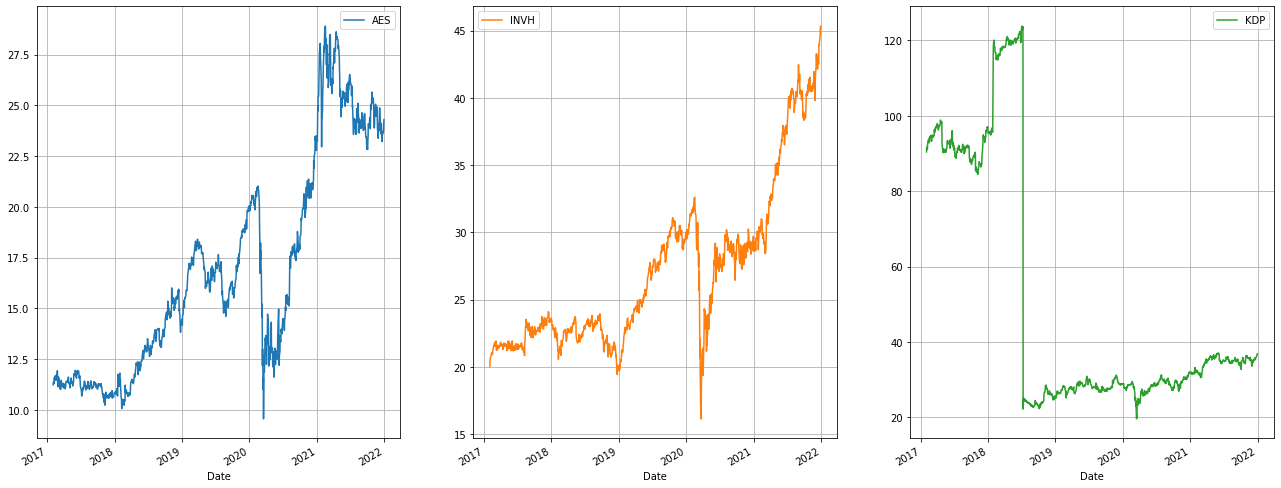

In [ ]:
# Visualize our stocks

stock_data.set_index('Date')[stocks].plot(subplots=True,grid=True, layout=(3,4),figsize=(30,30))

In [ ]:
# Create a function to calculate the return on the 3 stocks including allocation given a Moving Average Pair

def get_return(df, low_ma, high_ma, allocation):
    stock_columns = df.columns.values[2:]

#     Create the slow and fast moving average columns for each stock
    for col in stock_columns:
        df[col+' '+str(low_ma)+'-day'] = df[col].rolling(low_ma).mean().shift()
        df[col+' '+str(high_ma)+'-day'] = df[col].rolling(high_ma).mean().shift()

#         Visualize the MA columns
#         df[['Date', col+' '+str(low_ma)+'-day']].plot(figsize=(12,6))

#     Drop the rows with nan values
    df.dropna(inplace=True)

#     Add an 'invested' column for each stock to siginify whether we are investing or not
#     and a 'signal' column to signify when you enter or leave the market based on Momentum Trading Strategy
    for col in stock_columns:
        df[col+' invested'] = np.where(df[col+' '+str(low_ma)+'-day'] > df[col+' '+str(high_ma)+'-day'], 1, 0)

#         Check distribution of investments
#         print(df[col+' invested'].value_counts())

        df[col+' signal'] = df[col+' invested'].diff()

        #Put signal 1 on the first day - means that we buy on the first day
        df.loc[df['Date']==min(df['Date']), col+' signal'] = 1.0

    stock_returns = {}
    #Calculate the (buy and hold) return and (strategy) system return for each stock. Store these in above arrays
    for col in stock_columns:
        df[col+' logClose'] = np.log(df[col]) # price will always be positive, so this operation is well-defined
        df[col+ ' return'] = df[col+' logClose'].diff()

        #Assign return 0 to the first day
        df.loc[df['Date']==min(df['Date']), col+ ' return'] = 0.0

        df[col+ ' system_return'] = df[col+ ' invested'] * df[col+' return']

        stock_returns[col] = np.exp(np.sum(df[col+' system_return'])) -1

    print(f"Individual Stock Returns with pair ({low_ma}, {high_ma}) are:  {stock_returns}")

    portfolio_return = 0

    for stock in stock_columns:
        portfolio_return += stock_returns[stock]*allocation[stock]

    return df, portfolio_return

###**First Pair: 8,20**

In [ ]:
df, ret = get_return(stock_data.copy(), 8, 20, allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})
ret

Individual Stock Returns with pair (8, 20) are:  {'AES': 0.5399805560489981, 'INVH': 0.634673643457395, 'KDP': -0.7752058300778459}


-0.21051744654147983

###**Second Pair: 8,21**

In [ ]:
df, ret = get_return(stock_data.copy(), 8, 21, allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})
ret

Individual Stock Returns with pair (8, 21) are:  {'AES': 0.6191810269138724, 'INVH': 0.7457311857186257, 'KDP': -0.7696173452850645}


-0.16987050831689304

###**Third Pair: 9,20**

In [ ]:
df, ret = get_return(stock_data.copy(), 9, 20, allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})
ret

Individual Stock Returns with pair (9, 20) are:  {'AES': 0.7335514301242343, 'INVH': 0.6641006296913585, 'KDP': -0.7618293169391491}


-0.14279800722880193

###**Fourth Pair: 9,21**

In [ ]:
df, ret = get_return(stock_data.copy(), 9, 21, allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})
ret

Individual Stock Returns with pair (9, 21) are:  {'AES': 1.0675621410851837, 'INVH': 0.6746772642363918, 'KDP': -0.7687926498998305}


-0.048598671676467475

###**Fifth Pair: 8,22**

In [ ]:
df, ret = get_return(stock_data.copy(), 8, 22, allocation = {"AES":0.27, "INVH":0.15, "KDP":0.58})
ret

Individual Stock Returns with pair (8, 22) are:  {'AES': 0.8957351924601105, 'INVH': 0.5254882382499229, 'KDP': -0.7561958088255607}


-0.11792183141710694

###**Sixth Pair: 9,22**

In [ ]:
df, ret = get_return(stock_data.copy(), 9, 22, allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})
ret

Individual Stock Returns with pair (9, 22) are:  {'AES': 1.1283853640294277, 'INVH': 0.539662235853474, 'KDP': -0.7802041181417968}


-0.05513054229275649

### **Automate Pair selection process**

In [ ]:
# Function to run all pairs automatically and find best pair

def get_best_pair(stock_df, allocation):
    pairs = [(8,20), (8,21), (8,22), (9,20), (9,21), (9,22)]

    #highest variable stores the best pair return and best_pair variable stores the best pair found
    highest = -100
    best_pair = (0,0)
    best_df = None
    for pair in pairs:
        df, portfolio_return = get_return(stock_df.copy(), pair[0], pair[1], allocation)
        if portfolio_return > highest:
            highest = portfolio_return
            best_pair = pair
            best_df = df

    return best_pair, portfolio_return, best_df

In [ ]:
best_pair, portfolio_return, best_df = get_best_pair(stock_data.copy(), allocation = {"AES":0.29, "INVH":0.13, "KDP":0.58})

print(f"\nBest pair is {best_pair} with Portfolio return {portfolio_return}")

Individual Stock Returns with pair (8, 20) are:  {'AES': 0.5399805560489981, 'INVH': 0.634673643457395, 'KDP': -0.7752058300778459}
Individual Stock Returns with pair (8, 21) are:  {'AES': 0.6191810269138724, 'INVH': 0.7457311857186257, 'KDP': -0.7696173452850645}
Individual Stock Returns with pair (8, 22) are:  {'AES': 0.8957351924601105, 'INVH': 0.5254882382499229, 'KDP': -0.7561958088255607}
Individual Stock Returns with pair (9, 20) are:  {'AES': 0.7335514301242343, 'INVH': 0.6641006296913585, 'KDP': -0.7618293169391491}
Individual Stock Returns with pair (9, 21) are:  {'AES': 1.0675621410851837, 'INVH': 0.6746772642363918, 'KDP': -0.7687926498998305}
Individual Stock Returns with pair (9, 22) are:  {'AES': 1.1283853640294277, 'INVH': 0.539662235853474, 'KDP': -0.7802041181417968}

Best pair is (9, 21) with Portfolio return -0.05513054229275649


### **Visualize the data for winning pair**

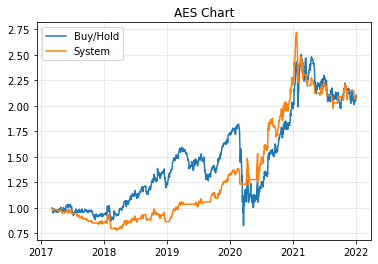

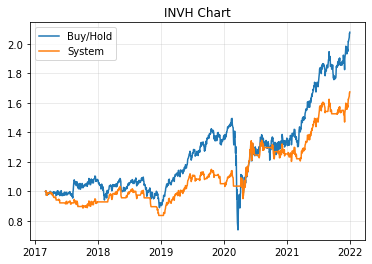

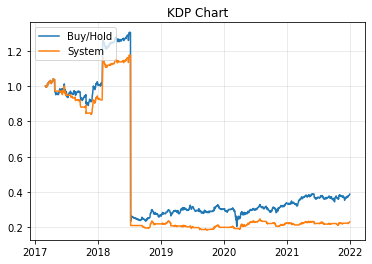

In [ ]:
best_df.set_index('Date', inplace=True)
for stock in stocks:
    plt.plot(np.exp(best_df[stock+' return']).cumprod(), label='Buy/Hold')
    plt.plot(np.exp(best_df[stock+' system_return']).cumprod(), label='System')
    plt.legend(loc=2)
    plt.title(f'{stock} Chart')
    plt.grid(True, alpha=.3)
    plt.show()

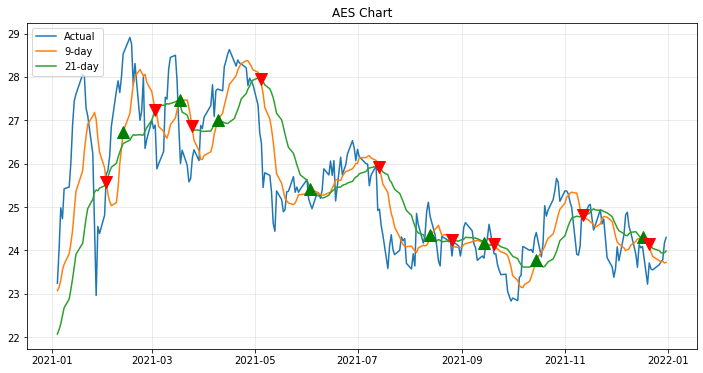

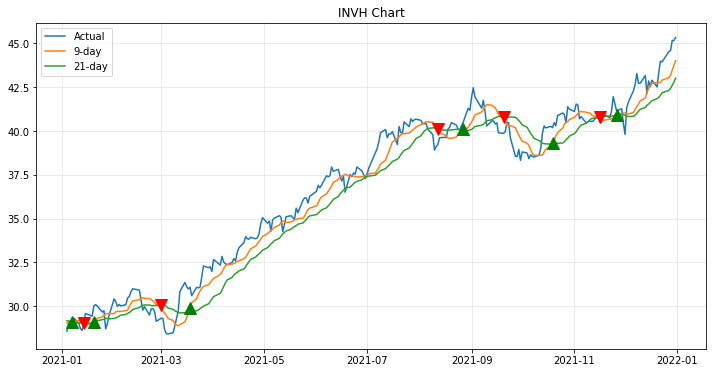

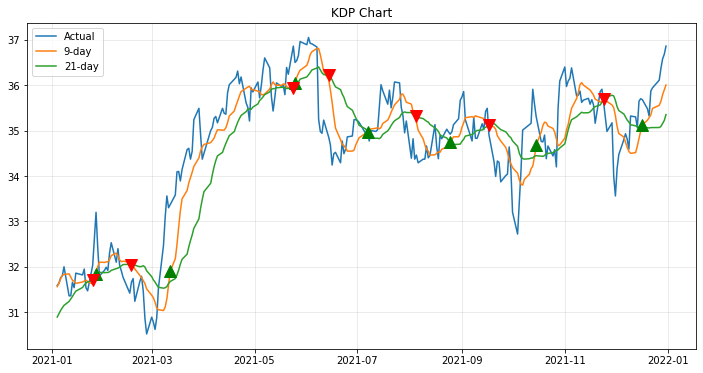

In [ ]:
# show the last year
for stock in stocks:
    plt.rcParams['figure.figsize'] = 12, 6
    plt.grid(True, alpha = .3)
    plt.plot(best_df.iloc[-252:][f'{stock}'], label = 'Actual') # actual value
    plt.plot(best_df.iloc[-252:][f'{stock} {best_pair[0]}-day'], label = f'{best_pair[0]}-day') # 9-day average
    plt.plot(best_df.iloc[-252:][f'{stock} {best_pair[1]}-day'], label = f'{best_pair[1]}-day') # 21-day average
    plt.plot(best_df[-252:].loc[best_df[f'{stock} signal'] == 1].index, best_df[-252:][f'{stock} {best_pair[0]}-day'][best_df[f'{stock} signal'] == 1], '^',
             color = 'g', markersize = 12)
    plt.plot(best_df[-252:].loc[best_df[f'{stock} signal'] == -1].index, best_df[-252:][f'{stock} {best_pair[1]}-day'][best_df[f'{stock} signal'] == -1], 'v',
             color = 'r', markersize = 12)
    plt.legend(loc=2)
    plt.title(f'{stock} Chart')
    plt.show()

# Analysis

##Portfolio returns evaluation


Final Allocation:

INVH 	0.13


AES 	0.29


KDP 	0.58


In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['INVH','AES','KDP']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2022',end_date='11/02/2022',interval='1mo') for ticker in tickers_list}

In [ ]:
dow_prices

{'INVH':                  open       high        low      close   adjclose     volume  \
 2022-01-01  45.389999  45.720001  39.564999  41.980000  40.985611   75855700   
 2022-02-01  42.189999  42.985001  36.150002  37.799999  36.904625  111354500   
 2022-03-01  37.680000  41.575001  37.070000  40.180000  39.433735  114702700   
 2022-04-01  40.160000  44.360001  39.669998  39.820000  39.080418   85490100   
 2022-05-01  39.799999  39.950001  35.250000  37.720001  37.019424   72018500   
 2022-06-01  37.820000  38.889999  33.150002  35.580002  35.122566   84076900   
 2022-07-01  35.490002  39.150002  34.310001  39.029999  38.528206   68756700   
 2022-08-01  38.959999  40.130001  35.863998  36.279999  35.813560   46760800   
 2022-09-01  36.049999  40.200001  33.494999  33.770000  33.530575  232467300   
 2022-10-01  34.240002  35.580002  30.200001  31.690001  31.465321   90729700   
 2022-11-01  31.940001  32.669998  29.559999  32.630001  32.398659   81643300   
 
            ticker

Calculating amount to be invested for INVH

In [ ]:
total_budget = 100000

invested_amount_INVH = 13000

jan_invh_close = 40.985611

nov_invh_close = 32.398659

invh_shares = round(invested_amount_INVH / jan_invh_close, 2)

invh_shares

317.18

In [ ]:
INVH_return = round(invh_shares * (nov_invh_close - jan_invh_close), 2)
print('Returns = $',INVH_return)

Returns = $ -2723.61


Calculating amount to be invested for AES

In [ ]:
invested_amount_AES = 29000

jan_aes_close = 21.572296

nov_aes_close = 28.920000

aes_shares = round(invested_amount_INVH / jan_aes_close, 2)

aes_shares

602.62

In [ ]:
aes_return = round(aes_shares * (nov_aes_close - jan_aes_close), 2)
print('$', aes_return)

$ 4427.87


Calculating amount to be invested for KDP

In [ ]:
invested_amount_KDP = 58000

jan_kdp_close = 37.170074

nov_kdp_close = 38.669998

kdp_shares = round(invested_amount_KDP / jan_kdp_close, 2)

kdp_shares

1560.4

In [ ]:
kdp_return = round(kdp_shares * (nov_kdp_close - jan_kdp_close), 2)
print('$', kdp_return)

$ 2340.48


Total returns obtained from these combination of stocks

In [ ]:
total_profit = INVH_return + aes_return + kdp_return
total_profit

4044.74

In [ ]:
profit_pct = (total_profit/total_budget)*100
print('Portfolio Retuns Pct:', round(profit_pct,2), '%')

Portfolio Retuns Pct: 4.04 %


##Implementing Buy & Hold strategy

###Obtaining the 2022 data

In [ ]:
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['INVH','AES','KDP']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2022',end_date='11/02/2022',interval='1d') for ticker in tickers_list}

In [ ]:
dow_prices['INVH']

,open,high,low,close,adjclose,volume,ticker
2022-01-03,45.389999,45.619999,44.008999,44.970001,43.904793,4325400,INVH
2022-01-04,44.990002,45.720001,44.990002,45.130001,44.060997,3216300,INVH
2022-01-05,45.230000,45.529999,43.779999,43.889999,42.850372,3806300,INVH
2022-01-06,43.970001,44.119999,43.540001,43.750000,42.713684,3193700,INVH
2022-01-07,43.529999,43.759998,42.665001,42.919998,41.903343,4345300,INVH
...,...,...,...,...,...,...,...
2022-10-26,33.939999,34.209999,33.570000,33.650002,33.411427,4325900,INVH
2022-10-27,30.200001,31.910000,30.200001,31.049999,30.829857,9353700,INVH
2022-10-28,30.850000,32.084999,30.700001,32.009998,31.783051,4524700,INVH
2022-10-31,31.780001,32.294998,31.670000,31.690001,31.465321,4465500,INVH


In [ ]:
dow_prices['AES']

,open,high,low,close,adjclose,volume,ticker
2022-01-03,24.410000,24.700001,24.040001,24.379999,23.712019,2741200,AES
2022-01-04,24.430000,24.660000,24.270000,24.450001,23.780102,4105000,AES
2022-01-05,24.350000,24.480000,23.320000,23.330000,22.690788,6392500,AES
2022-01-06,23.340000,23.700001,23.160000,23.240000,22.603254,6035900,AES
2022-01-07,23.240000,23.469999,22.980000,23.100000,22.467093,4655400,AES
...,...,...,...,...,...,...,...
2022-10-26,25.299999,25.740000,25.150000,25.450001,25.298033,3305400,AES
2022-10-27,25.770000,26.170000,25.650000,25.770000,25.616121,3732300,AES
2022-10-28,25.910000,26.480000,25.760000,26.459999,26.302000,5180300,AES
2022-10-31,26.250000,26.379999,25.980000,26.160000,26.160000,4763400,AES


In [ ]:
dow_prices['KDP']

,open,high,low,close,adjclose,volume,ticker
2022-01-03,36.639999,36.759998,36.250000,36.709999,35.955559,3508900,KDP
2022-01-04,36.790001,37.400002,36.770000,37.259998,36.494255,5305600,KDP
2022-01-05,36.930000,37.540001,36.770000,37.029999,36.452908,5777400,KDP
2022-01-06,36.980000,37.889999,36.980000,37.430000,36.846680,6505000,KDP
2022-01-07,37.299999,37.410000,36.990002,37.299999,36.718700,4939200,KDP
...,...,...,...,...,...,...,...
2022-10-26,38.830002,39.160000,38.619999,38.759998,38.759998,7665600,KDP
2022-10-27,37.619999,38.130001,37.250000,38.110001,38.110001,7209100,KDP
2022-10-28,38.340000,39.730000,38.340000,39.549999,39.549999,8038300,KDP
2022-10-31,38.959999,39.150002,38.509998,38.840000,38.840000,6865800,KDP


In [ ]:
# extract just the data we need (adjclose)
prep_data = {}
for i in tickers_list:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose']).rename(columns = {"adjclose":i})
  prep_data[i] = prep_data[i].resample('D').max().ffill()  # resample to a 1 day granularity incase some of the days are missing
                                # forward fill the missing values

In [ ]:
# combine all the tickers
df = pd.concat([prep_data[i] for i in tickers_list], axis=1)
df  # since the date range are not consistant, there're many missing values

,INVH,AES,KDP
2022-01-03,43.904793,23.712019,35.955559
2022-01-04,44.060997,23.780102,36.494255
2022-01-05,42.850372,22.690788,36.452908
2022-01-06,42.713684,22.603254,36.846680
2022-01-07,41.903343,22.467093,36.718700
...,...,...,...
2022-10-28,31.783051,26.302000,39.549999
2022-10-29,31.783051,26.302000,39.549999
2022-10-30,31.783051,26.302000,39.549999
2022-10-31,31.465321,26.160000,38.840000


###For INVH Stock

In [ ]:
from pandas.core.arrays import interval
import pandas_datareader as pdr
from datetime import datetime

myStock = 'INVH'
gld_INVH = pdr.get_data_yahoo(myStock, start=datetime(2022, 1, 1), end=datetime(2022, 11, 2), interval = 'd')

gld_INVH.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld_INVH = gld_INVH[['Open', 'High', 'Low', 'Close']]
gld_INVH

,Open,High,Low,Close
Date,,,,
2022-01-03,45.389999,45.619999,44.008999,44.970001
2022-01-04,44.990002,45.720001,44.990002,45.130001
2022-01-05,45.230000,45.529999,43.779999,43.889999
2022-01-06,43.970001,44.119999,43.540001,43.750000
2022-01-07,43.529999,43.759998,42.665001,42.919998
...,...,...,...,...
2022-10-27,30.200001,31.910000,30.200001,31.049999
2022-10-28,30.850000,32.084999,30.700001,32.009998
2022-10-31,31.780001,32.294998,31.670000,31.690001


####Add data/transform data

In [ ]:
gld_INVH['9-day'] = gld_INVH['Close'].rolling(9).mean().shift()
gld_INVH['21-day'] = gld_INVH['Close'].rolling(21).mean().shift()
gld_INVH

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,45.389999,45.619999,44.008999,44.970001,NaN,NaN
2022-01-04,44.990002,45.720001,44.990002,45.130001,NaN,NaN
2022-01-05,45.230000,45.529999,43.779999,43.889999,NaN,NaN
2022-01-06,43.970001,44.119999,43.540001,43.750000,NaN,NaN
2022-01-07,43.529999,43.759998,42.665001,42.919998,NaN,NaN
...,...,...,...,...,...,...
2022-10-27,30.200001,31.910000,30.200001,31.049999,32.931111,33.266667
2022-10-28,30.850000,32.084999,30.700001,32.009998,32.870000,33.102857
2022-10-31,31.780001,32.294998,31.670000,31.690001,32.775556,33.013810


In [ ]:
gld_INVH.head(n =30)

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,45.389999,45.619999,44.008999,44.970001,NaN,NaN
2022-01-04,44.990002,45.720001,44.990002,45.130001,NaN,NaN
2022-01-05,45.230000,45.529999,43.779999,43.889999,NaN,NaN
2022-01-06,43.970001,44.119999,43.540001,43.750000,NaN,NaN
2022-01-07,43.529999,43.759998,42.665001,42.919998,NaN,NaN
2022-01-10,42.500000,42.650002,41.990002,42.639999,NaN,NaN
2022-01-11,42.680000,43.220001,42.209999,43.160000,NaN,NaN
2022-01-12,43.080002,43.590000,43.029999,43.459999,NaN,NaN
2022-01-13,43.560001,43.820000,43.180000,43.619999,NaN,NaN


In [ ]:
gld_INVH.dropna(inplace=True)
gld_INVH

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952
...,...,...,...,...,...,...
2022-10-27,30.200001,31.910000,30.200001,31.049999,32.931111,33.266667
2022-10-28,30.850000,32.084999,30.700001,32.009998,32.870000,33.102857
2022-10-31,31.780001,32.294998,31.670000,31.690001,32.775556,33.013810


####Buy and Hold strategy

In [ ]:
gld_INVH['logClose'] = np.log(gld_INVH['Close']) # price will always be positive, so this operation is well-defined
gld_INVH['return'] = gld_INVH['logClose'].diff() # the difference will be positive or negative
gld_INVH

,Open,High,Low,Close,9-day,21-day,logClose,return
Date,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,NaN
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523,3.747148,-0.004706
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523,3.747856,0.000707
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000,3.729781,-0.018074
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952,3.732657,0.002876
...,...,...,...,...,...,...,...,...
2022-10-27,30.200001,31.910000,30.200001,31.049999,32.931111,33.266667,3.435599,-0.080414
2022-10-28,30.850000,32.084999,30.700001,32.009998,32.870000,33.102857,3.466048,0.030450
2022-10-31,31.780001,32.294998,31.670000,31.690001,32.775556,33.013810,3.456001,-0.010047


#####Replacing the null value for calculation

In [ ]:
gld_INVH.loc["2022-02-02",'return'] = 0.0

#####Buy and Hold Returns

In [ ]:
INVH_BnH_pct = np.exp(np.sum(gld_INVH['return'])) -1
INVH_BnH_pct

-0.26150234245702697

In [ ]:
# INVH_BnH_return = invested_amount_INVH * INVH_BnH_pct
# INVH_BnH_return

####Momentum trading strategy

##### Add "invested" column  
The purpose of this column is to show whether we are currently investing money or if we are out of the market. More precisely, **invested = 1 if the 9-day average is greater than the 21-day average**.

In [ ]:
# the np.where() function is similar to the Excel =IF() statement
gld_INVH['invested'] = np.where(gld_INVH['9-day'] > gld_INVH['21-day'], 1, 0)
gld_INVH

,Open,High,Low,Close,9-day,21-day,logClose,return,invested
Date,,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,0.000000,0
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523,3.747148,-0.004706,0
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523,3.747856,0.000707,0
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000,3.729781,-0.018074,0
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952,3.732657,0.002876,0
...,...,...,...,...,...,...,...,...,...
2022-10-27,30.200001,31.910000,30.200001,31.049999,32.931111,33.266667,3.435599,-0.080414,0
2022-10-28,30.850000,32.084999,30.700001,32.009998,32.870000,33.102857,3.466048,0.030450,0
2022-10-31,31.780001,32.294998,31.670000,31.690001,32.775556,33.013810,3.456001,-0.010047,0


In [ ]:
print(gld_INVH['invested'].value_counts())

0    102
1     88
Name: invested, dtype: int64


#### Entering and leaving the market using the momentum trading strategy

Now we make a column called 'signal' which tells you when you enter and leave the market based on the momentum trading strategy. Remember that we want to **buy/sell at the transition points**, i.e., when the plots are intersecting and the trend is changing.

A value of +1 indicates that we should buy, and a value of -1 indicates that we should sell. Observe that this happens when the trend flips.


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
gld_INVH['signal'] = gld_INVH['invested'].diff()
print(gld_INVH['signal'].value_counts())

 0.0    177
 1.0      6
-1.0      6
Name: signal, dtype: int64


In [ ]:
gld_INVH.head(5)

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,0.000000,0,NaN
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523,3.747148,-0.004706,0,0.0
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523,3.747856,0.000707,0,0.0
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000,3.729781,-0.018074,0,0.0
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952,3.732657,0.002876,0,0.0


In [ ]:
gld_INVH.loc["2022-02-02",'signal'] = 1.0
gld_INVH.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,0.000000,0,1.0
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523,3.747148,-0.004706,0,0.0
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523,3.747856,0.000707,0,0.0
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000,3.729781,-0.018074,0,0.0
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952,3.732657,0.002876,0,0.0


#####Trading days

In [ ]:
gld_INVH[gld_INVH['signal'].isin([1,-1])]

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,0.000000,0,1.0
2022-02-11,42.160000,42.450001,41.345001,41.830002,42.192222,42.150952,3.733614,-0.009280,1,1.0
2022-02-18,38.669998,39.299999,38.360001,38.619999,41.423333,41.566667,3.653770,-0.016945,0,-1.0
2022-03-16,39.880001,40.360001,39.009998,39.799999,39.062222,39.015714,3.683867,0.007566,1,1.0
2022-05-04,38.349998,38.980000,37.700001,38.750000,41.251111,41.411428,3.657131,0.006992,0,-1.0
2022-06-02,37.910000,38.830002,37.560001,38.799999,37.282222,37.055238,3.658420,0.019782,1,1.0
2022-06-15,33.930000,34.825001,33.709999,34.240002,36.728889,36.909048,3.533395,0.017976,0,-1.0
2022-07-07,36.580002,36.814999,36.380001,36.590000,35.704445,35.460476,3.599775,0.005756,1,1.0
2022-07-22,36.470001,36.880001,36.189999,36.450001,35.644445,35.678572,3.595941,0.006330,0,-1.0


#####Momentum Trading Returns

In [ ]:
# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
gld_INVH['system_return'] = gld_INVH['invested'] * gld_INVH['return']
gld_INVH.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal,system_return
Date,,,,,,,,,,,
2022-02-02,42.099998,42.810001,41.820000,42.599998,41.406667,42.652381,3.751854,0.000000,0,1.0,0.0
2022-02-03,42.169998,42.709999,42.169998,42.400002,41.491111,42.539523,3.747148,-0.004706,0,0.0,-0.0
2022-02-04,42.220001,42.985001,41.919998,42.430000,41.548889,42.409523,3.747856,0.000707,0,0.0,0.0
2022-02-07,42.459999,42.619999,41.630001,41.669998,41.631111,42.340000,3.729781,-0.018074,0,0.0,-0.0
2022-02-08,41.610001,42.240002,41.500000,41.790001,41.694444,42.240952,3.732657,0.002876,0,0.0,0.0


In [ ]:
INVH_mt_sys = np.exp(np.sum(gld_INVH['system_return'])) -1
INVH_mt_sys

-0.25590142540711414

In [ ]:
INVH_mt_pct = np.exp(np.sum(gld_INVH['return'])) -1

INVH_mt_pct

-0.26150234245702697

In [ ]:
# INVH_mt_return = invested_amount_INVH * INVH_mt_pct
# INVH_mt_return

In [ ]:
# gld_INVH['firstDay'] = gld_INVH['Date'] - pd.offsets.MonthBegin(1, normalize=True)

#####Plotting trades

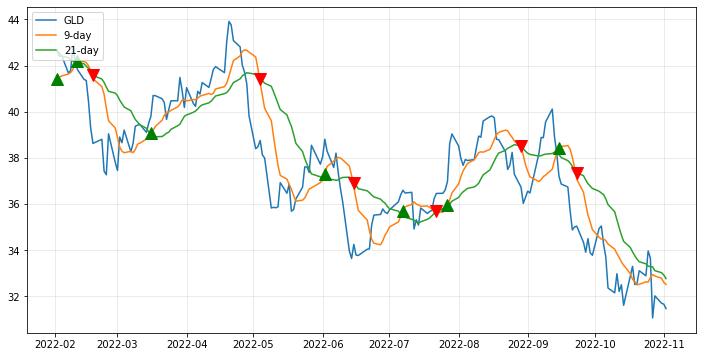

In [ ]:
# show the 2022 year
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld_INVH.iloc[-252:]['Close'], label = 'GLD') # actual value
plt.plot(gld_INVH.iloc[-252:]['9-day'], label = '9-day') # 9-day average
plt.plot(gld_INVH.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld_INVH[-252:].loc[gld_INVH.signal == 1].index, gld_INVH[-252:]['9-day'][gld_INVH.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld_INVH[-252:].loc[gld_INVH.signal == -1].index, gld_INVH[-252:]['21-day'][gld_INVH.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

In [ ]:
gld_INVH.columns

Index(['Open', 'High', 'Low', 'Close', '9-day', '21-day', 'logClose', 'return',
       'invested', 'signal', 'system_return'],
      dtype='object')

#####INVH Results

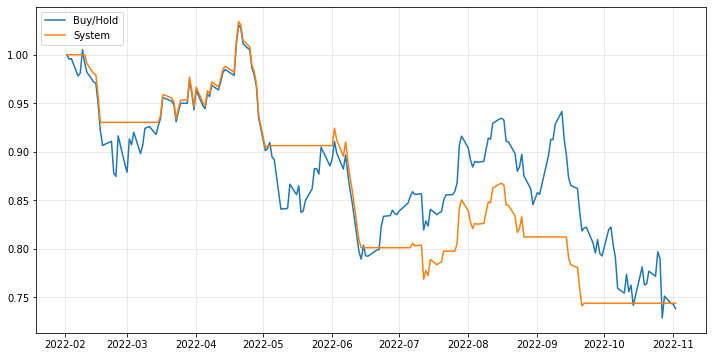

In [ ]:
plt.plot(np.exp(gld_INVH['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld_INVH['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

###For AES Stock

In [ ]:
from pandas.core.arrays import interval
import pandas_datareader as pdr
from datetime import datetime

myStock = 'AES'
gld_AES = pdr.get_data_yahoo(myStock, start=datetime(2022, 1, 1), end=datetime(2022, 11, 2), interval = 'd')

gld_AES.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld_AES = gld_AES[['Open', 'High', 'Low', 'Close']]
gld_AES

,Open,High,Low,Close
Date,,,,
2022-01-03,24.41,24.700001,24.040001,24.379999
2022-01-04,24.43,24.660000,24.270000,24.450001
2022-01-05,24.35,24.480000,23.320000,23.330000
2022-01-06,23.34,23.700001,23.160000,23.240000
2022-01-07,23.24,23.469999,22.980000,23.100000
...,...,...,...,...
2022-10-27,25.77,26.170000,25.650000,25.770000
2022-10-28,25.91,26.480000,25.760000,26.459999
2022-10-31,26.25,26.379999,25.980000,26.160000


####Add data/transform data

In [ ]:
gld_AES['9-day'] = gld_AES['Close'].rolling(9).mean().shift()
gld_AES['21-day'] = gld_AES['Close'].rolling(21).mean().shift()
gld_AES

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,24.41,24.700001,24.040001,24.379999,NaN,NaN
2022-01-04,24.43,24.660000,24.270000,24.450001,NaN,NaN
2022-01-05,24.35,24.480000,23.320000,23.330000,NaN,NaN
2022-01-06,23.34,23.700001,23.160000,23.240000,NaN,NaN
2022-01-07,23.24,23.469999,22.980000,23.100000,NaN,NaN
...,...,...,...,...,...,...
2022-10-27,25.77,26.170000,25.650000,25.770000,24.324444,24.284286
2022-10-28,25.91,26.480000,25.760000,26.459999,24.597778,24.414762
2022-10-31,26.25,26.379999,25.980000,26.160000,24.884444,24.591428


In [ ]:
gld_AES.head(n =30)

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,24.410000,24.700001,24.040001,24.379999,NaN,NaN
2022-01-04,24.430000,24.660000,24.270000,24.450001,NaN,NaN
2022-01-05,24.350000,24.480000,23.320000,23.330000,NaN,NaN
2022-01-06,23.340000,23.700001,23.160000,23.240000,NaN,NaN
2022-01-07,23.240000,23.469999,22.980000,23.100000,NaN,NaN
2022-01-10,23.150000,23.309999,22.680000,22.959999,NaN,NaN
2022-01-11,23.000000,23.389999,23.000000,23.340000,NaN,NaN
2022-01-12,23.440001,23.700001,23.250000,23.430000,NaN,NaN
2022-01-13,23.440001,23.680000,23.219999,23.270000,NaN,NaN


In [ ]:
gld_AES.dropna(inplace=True)
gld_AES

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809
...,...,...,...,...,...,...
2022-10-27,25.770000,26.170000,25.650000,25.770000,24.324444,24.284286
2022-10-28,25.910000,26.480000,25.760000,26.459999,24.597778,24.414762
2022-10-31,26.250000,26.379999,25.980000,26.160000,24.884444,24.591428


####Buy and Hold strategy

In [ ]:
gld_AES['logClose'] = np.log(gld_AES['Close']) # price will always be positive, so this operation is well-defined
gld_AES['return'] = gld_AES['logClose'].diff() # the difference will be positive or negative
gld_AES

,Open,High,Low,Close,9-day,21-day,logClose,return
Date,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,NaN
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095,3.080073,-0.024962
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000,3.086943,0.006870
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381,3.081910,-0.005033
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809,3.113071,0.031161
...,...,...,...,...,...,...,...,...
2022-10-27,25.770000,26.170000,25.650000,25.770000,24.324444,24.284286,3.249211,0.012495
2022-10-28,25.910000,26.480000,25.760000,26.459999,24.597778,24.414762,3.275634,0.026423
2022-10-31,26.250000,26.379999,25.980000,26.160000,24.884444,24.591428,3.264232,-0.011403


#####Replacing the null value for calculation

In [ ]:
gld_AES.loc["2022-02-02",'return'] = 0.0

#####Buy and Hold Returns

In [ ]:
AES_BnH_pct = np.exp(np.sum(gld_AES['return'])) -1
AES_BnH_pct

0.15777680600742183

In [ ]:
# AES_BnH_return = invested_amount_AES * AES_BnH_pct
# AES_BnH_return

####Momentum trading strategy

##### Add "invested" column  
The purpose of this column is to show whether we are currently investing money or if we are out of the market. More precisely, **invested = 1 if the 9-day average is greater than the 21-day average**.

In [ ]:
# the np.where() function is similar to the Excel =IF() statement
gld_AES['invested'] = np.where(gld_AES['9-day'] > gld_AES['21-day'], 1, 0)
gld_AES

,Open,High,Low,Close,9-day,21-day,logClose,return,invested
Date,,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,0.000000,0
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095,3.080073,-0.024962,0
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000,3.086943,0.006870,0
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381,3.081910,-0.005033,0
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809,3.113071,0.031161,0
...,...,...,...,...,...,...,...,...,...
2022-10-27,25.770000,26.170000,25.650000,25.770000,24.324444,24.284286,3.249211,0.012495,1
2022-10-28,25.910000,26.480000,25.760000,26.459999,24.597778,24.414762,3.275634,0.026423,1
2022-10-31,26.250000,26.379999,25.980000,26.160000,24.884444,24.591428,3.264232,-0.011403,1


In [ ]:
print(gld_AES['invested'].value_counts())

1    104
0     86
Name: invested, dtype: int64


#### Entering and leaving the market using the momentum trading strategy

Now we make a column called 'signal' which tells you when you enter and leave the market based on the momentum trading strategy. Remember that we want to **buy/sell at the transition points**, i.e., when the plots are intersecting and the trend is changing.

A value of +1 indicates that we should buy, and a value of -1 indicates that we should sell. Observe that this happens when the trend flips.


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
gld_AES['signal'] = gld_AES['invested'].diff()
print(gld_AES['signal'].value_counts())

 0.0    180
 1.0      5
-1.0      4
Name: signal, dtype: int64


In [ ]:
gld_AES.head(5)

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,0.000000,0,NaN
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095,3.080073,-0.024962,0,0.0
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000,3.086943,0.006870,0,0.0
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381,3.081910,-0.005033,0,0.0
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809,3.113071,0.031161,0,0.0


In [ ]:
gld_AES.loc["2022-02-02",'signal'] = 1.0
gld_AES.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,0.000000,0,1.0
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095,3.080073,-0.024962,0,0.0
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000,3.086943,0.006870,0,0.0
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381,3.081910,-0.005033,0,0.0
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809,3.113071,0.031161,0,0.0


#####Trading days

In [ ]:
gld_AES[gld_AES['signal'].isin([1,-1])]

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,0.000000,0,1.0
2022-03-11,22.389999,22.740000,22.190001,22.200001,21.592222,21.544762,3.100092,-0.006734,1,1.0
2022-04-20,24.740000,25.400000,24.430000,24.910000,24.675556,24.804286,3.215269,0.019867,0,-1.0
2022-05-26,21.570000,22.230000,21.530001,22.000000,20.698889,20.656667,3.091042,0.026251,1,1.0
2022-06-16,19.000000,19.270000,18.700001,18.940001,21.105555,21.258571,2.941276,-0.031699,0,-1.0
2022-07-05,21.160000,21.219999,20.610001,21.180000,20.861111,20.858571,3.053057,-0.014065,1,1.0
2022-07-21,19.950001,20.129999,19.770000,19.910000,20.725556,20.852857,2.991222,-0.003510,0,-1.0
2022-08-03,22.490000,22.580000,22.059999,22.549999,21.024444,20.922857,3.115735,0.014292,1,1.0
2022-09-26,24.139999,24.209999,22.940001,22.959999,25.964445,26.170000,3.133754,-0.056311,0,-1.0


#####Momentum Trading Returns

In [ ]:
# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
gld_AES['system_return'] = gld_AES['invested'] * gld_AES['return']
gld_AES.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal,system_return
Date,,,,,,,,,,,
2022-02-02,22.090000,22.360001,21.850000,22.309999,22.453333,22.966667,3.105035,0.000000,0,1.0,0.0
2022-02-03,22.040001,22.260000,21.709999,21.760000,22.333333,22.868095,3.080073,-0.024962,0,0.0,-0.0
2022-02-04,21.629999,22.090000,21.510000,21.910000,22.201111,22.740000,3.086943,0.006870,0,0.0,0.0
2022-02-07,21.860001,22.070000,21.600000,21.799999,22.125555,22.672381,3.081910,-0.005033,0,0.0,-0.0
2022-02-08,21.900000,22.559999,21.820000,22.490000,22.084444,22.603809,3.113071,0.031161,0,0.0,0.0


In [ ]:
AES_mt_sys = np.exp(np.sum(gld_AES['system_return'])) -1
AES_mt_sys

0.07244878755649342

In [ ]:
AES_mt_pct = np.exp(np.sum(gld_AES['return'])) -1

AES_mt_pct

0.15777680600742183

In [ ]:
# AES_mt_return = invested_amount_AES * AES_mt_pct
# AES_mt_return

#####Plotting trades

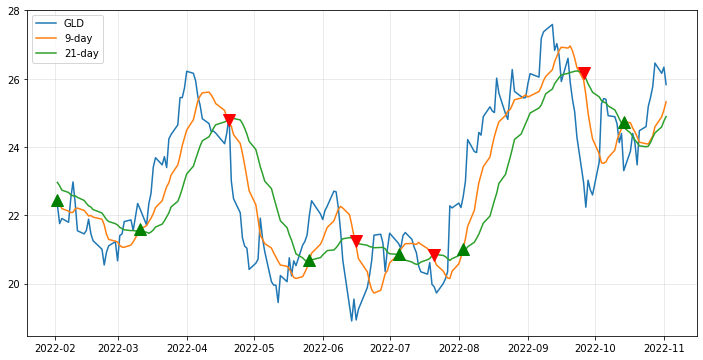

In [ ]:
# show the 2022 year
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld_AES.iloc[-252:]['Close'], label = 'GLD') # actual value
plt.plot(gld_AES.iloc[-252:]['9-day'], label = '9-day') # 9-day average
plt.plot(gld_AES.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld_AES[-252:].loc[gld_AES.signal == 1].index, gld_AES[-252:]['9-day'][gld_AES.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld_AES[-252:].loc[gld_AES.signal == -1].index, gld_AES[-252:]['21-day'][gld_AES.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

In [ ]:
gld_AES.columns

Index(['Open', 'High', 'Low', 'Close', '9-day', '21-day', 'logClose', 'return',
       'invested', 'signal', 'system_return'],
      dtype='object')

#####AES Results

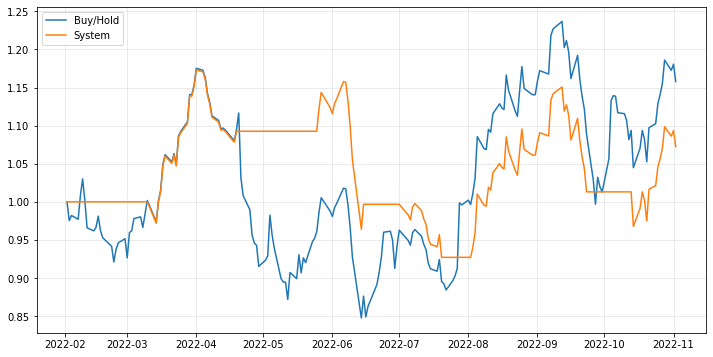

In [ ]:
plt.plot(np.exp(gld_AES['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld_AES['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

###For KDP Stock

In [ ]:
from pandas.core.arrays import interval
import pandas_datareader as pdr
from datetime import datetime

myStock = 'KDP'
gld_KDP = pdr.get_data_yahoo(myStock, start=datetime(2022, 1, 1), end=datetime(2022, 11, 2), interval = 'd')

gld_KDP.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld_KDP = gld_KDP[['Open', 'High', 'Low', 'Close']]
gld_KDP

,Open,High,Low,Close
Date,,,,
2022-01-03,36.639999,36.759998,36.250000,36.709999
2022-01-04,36.790001,37.400002,36.770000,37.259998
2022-01-05,36.930000,37.540001,36.770000,37.029999
2022-01-06,36.980000,37.889999,36.980000,37.430000
2022-01-07,37.299999,37.410000,36.990002,37.299999
...,...,...,...,...
2022-10-27,37.619999,38.130001,37.250000,38.110001
2022-10-28,38.340000,39.730000,38.340000,39.549999
2022-10-31,38.959999,39.150002,38.509998,38.840000


####Add data/transform data

In [ ]:
gld_KDP['9-day'] = gld_KDP['Close'].rolling(9).mean().shift()
gld_KDP['21-day'] = gld_KDP['Close'].rolling(21).mean().shift()
gld_KDP

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,36.639999,36.759998,36.250000,36.709999,NaN,NaN
2022-01-04,36.790001,37.400002,36.770000,37.259998,NaN,NaN
2022-01-05,36.930000,37.540001,36.770000,37.029999,NaN,NaN
2022-01-06,36.980000,37.889999,36.980000,37.430000,NaN,NaN
2022-01-07,37.299999,37.410000,36.990002,37.299999,NaN,NaN
...,...,...,...,...,...,...
2022-10-27,37.619999,38.130001,37.250000,38.110001,37.987777,37.427618
2022-10-28,38.340000,39.730000,38.340000,39.549999,38.074443,37.500952
2022-10-31,38.959999,39.150002,38.509998,38.840000,38.273332,37.664285


In [ ]:
gld_KDP.head(n =30)

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-01-03,36.639999,36.759998,36.250000,36.709999,NaN,NaN
2022-01-04,36.790001,37.400002,36.770000,37.259998,NaN,NaN
2022-01-05,36.930000,37.540001,36.770000,37.029999,NaN,NaN
2022-01-06,36.980000,37.889999,36.980000,37.430000,NaN,NaN
2022-01-07,37.299999,37.410000,36.990002,37.299999,NaN,NaN
2022-01-10,37.360001,37.549999,37.119999,37.310001,NaN,NaN
2022-01-11,37.220001,37.900002,37.000000,37.830002,NaN,NaN
2022-01-12,37.740002,38.029999,37.549999,38.009998,NaN,NaN
2022-01-13,38.049999,38.509998,37.860001,38.450001,NaN,NaN


In [ ]:
gld_KDP.dropna(inplace=True)
gld_KDP

,Open,High,Low,Close,9-day,21-day
Date,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810
...,...,...,...,...,...,...
2022-10-27,37.619999,38.130001,37.250000,38.110001,37.987777,37.427618
2022-10-28,38.340000,39.730000,38.340000,39.549999,38.074443,37.500952
2022-10-31,38.959999,39.150002,38.509998,38.840000,38.273332,37.664285


####Buy and Hold strategy

In [ ]:
gld_KDP['logClose'] = np.log(gld_KDP['Close']) # price will always be positive, so this operation is well-defined
gld_KDP['return'] = gld_KDP['logClose'].diff() # the difference will be positive or negative
gld_KDP

,Open,High,Low,Close,9-day,21-day,logClose,return
Date,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,NaN
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952,3.657131,-0.000516
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905,3.643882,-0.013249
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524,3.652475,0.008593
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810,3.659708,0.007233
...,...,...,...,...,...,...,...,...
2022-10-27,37.619999,38.130001,37.250000,38.110001,37.987777,37.427618,3.640477,-0.016912
2022-10-28,38.340000,39.730000,38.340000,39.549999,38.074443,37.500952,3.677566,0.037089
2022-10-31,38.959999,39.150002,38.509998,38.840000,38.273332,37.664285,3.659451,-0.018115


#####Replacing the null value for calculation

In [ ]:
gld_KDP.loc["2022-02-02",'return'] = 0.0

#####Buy and Hold Returns

In [ ]:
KDP_BnH_pct = np.exp(np.sum(gld_KDP['return'])) -1
KDP_BnH_pct

-0.04616974192397527

In [ ]:
# KDP_BnH_return = invested_amount_KDP * KDP_BnH_pct
# KDP_BnH_return

####Momentum trading strategy

##### Add "invested" column  
The purpose of this column is to show whether we are currently investing money or if we are out of the market. More precisely, **invested = 1 if the 9-day average is greater than the 21-day average**.

In [ ]:
# the np.where() function is similar to the Excel =IF() statement
gld_KDP['invested'] = np.where(gld_KDP['9-day'] > gld_KDP['21-day'], 1, 0)
gld_KDP

,Open,High,Low,Close,9-day,21-day,logClose,return,invested
Date,,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,0.000000,1
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952,3.657131,-0.000516,1
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905,3.643882,-0.013249,1
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524,3.652475,0.008593,1
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810,3.659708,0.007233,1
...,...,...,...,...,...,...,...,...,...
2022-10-27,37.619999,38.130001,37.250000,38.110001,37.987777,37.427618,3.640477,-0.016912,1
2022-10-28,38.340000,39.730000,38.340000,39.549999,38.074443,37.500952,3.677566,0.037089,1
2022-10-31,38.959999,39.150002,38.509998,38.840000,38.273332,37.664285,3.659451,-0.018115,1


In [ ]:
print(gld_KDP['invested'].value_counts())

0    102
1     88
Name: invested, dtype: int64


#### Entering and leaving the market using the momentum trading strategy

Now we make a column called 'signal' which tells you when you enter and leave the market based on the momentum trading strategy. Remember that we want to **buy/sell at the transition points**, i.e., when the plots are intersecting and the trend is changing.

A value of +1 indicates that we should buy, and a value of -1 indicates that we should sell. Observe that this happens when the trend flips.


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
gld_KDP['signal'] = gld_KDP['invested'].diff()
print(gld_KDP['signal'].value_counts())

 0.0    179
-1.0      5
 1.0      5
Name: signal, dtype: int64


In [ ]:
gld_KDP.head(5)

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,0.000000,1,NaN
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952,3.657131,-0.000516,1,0.0
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905,3.643882,-0.013249,1,0.0
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524,3.652475,0.008593,1,0.0
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810,3.659708,0.007233,1,0.0


In [ ]:
gld_KDP.loc["2022-02-02",'signal'] = 1.0
gld_KDP.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,0.000000,1,1.0
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952,3.657131,-0.000516,1,0.0
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905,3.643882,-0.013249,1,0.0
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524,3.652475,0.008593,1,0.0
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810,3.659708,0.007233,1,0.0


#####Trading days

In [ ]:
gld_KDP[gld_AES['signal'].isin([1,-1])]

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal
Date,,,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,0.000000,1,1.0
2022-03-11,37.340000,37.750000,36.750000,36.810001,38.123333,38.096666,3.605770,-0.010539,1,0.0
2022-04-20,37.700001,38.049999,37.529999,38.009998,37.505556,37.655239,3.637849,0.011910,0,0.0
2022-05-26,35.380001,35.770000,35.270000,35.529999,35.464445,36.467143,3.570377,0.005362,0,0.0
2022-06-16,34.520000,34.900002,34.320000,34.439999,35.468889,35.220000,3.539219,-0.011834,1,0.0
2022-07-05,36.080002,36.270000,35.439999,36.259998,35.481110,35.364762,3.590715,0.005254,1,1.0
2022-07-21,36.270000,36.459999,35.950001,36.279999,36.337778,35.939524,3.591267,-0.000827,1,0.0
2022-08-03,38.610001,39.150002,38.250000,39.099998,37.595556,36.845714,3.666122,0.013907,1,0.0
2022-09-26,37.020000,37.529999,36.950001,37.279999,37.375556,38.012381,3.618457,0.005379,0,0.0


##### Momentum Trading Returns

In [ ]:
# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
gld_KDP['system_return'] = gld_KDP['invested'] * gld_KDP['return']
gld_KDP.head()

,Open,High,Low,Close,9-day,21-day,logClose,return,invested,signal,system_return
Date,,,,,,,,,,,
2022-02-02,38.299999,38.889999,38.169998,38.770000,37.881111,37.812857,3.657647,0.000000,1,1.0,0.000000
2022-02-03,38.740002,39.049999,38.419998,38.750000,37.954444,37.910952,3.657131,-0.000516,1,0.0,-0.000516
2022-02-04,38.389999,38.650002,37.880001,38.240002,38.056666,37.981905,3.643882,-0.013249,1,0.0,-0.013249
2022-02-07,38.330002,38.730000,38.150002,38.570000,38.064445,38.039524,3.652475,0.008593,1,0.0,0.008593
2022-02-08,38.669998,39.029999,38.480000,38.849998,38.118889,38.093810,3.659708,0.007233,1,0.0,0.007233


In [ ]:
KDP_mt_sys = np.exp(np.sum(gld_KDP['system_return'])) -1
KDP_mt_sys

-0.021914747202468998

In [ ]:
KDP_mt_pct = np.exp(np.sum(gld_KDP['return'])) -1

KDP_mt_pct

-0.04616974192397527

In [ ]:
# KDP_mt_return = invested_amount_KDP * KDP_mt_pct
# KDP_mt_return

#####Plotting trades

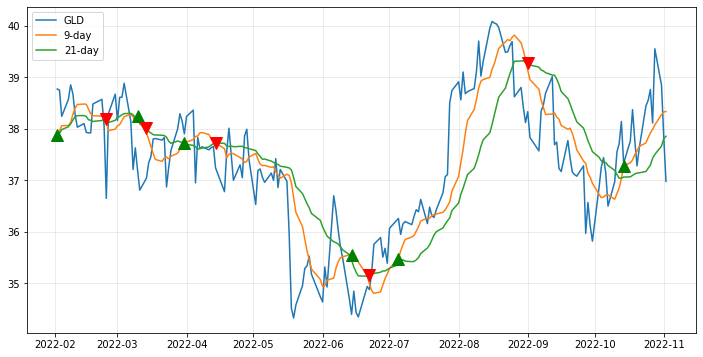

In [ ]:
# show the 2022 year
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld_KDP.iloc[-252:]['Close'], label = 'GLD') # actual value
plt.plot(gld_KDP.iloc[-252:]['9-day'], label = '9-day') # 9-day average
plt.plot(gld_KDP.iloc[-252:]['21-day'], label = '21-day') # 21-day average
plt.plot(gld_KDP[-252:].loc[gld_KDP.signal == 1].index, gld_KDP[-252:]['9-day'][gld_KDP.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(gld_KDP[-252:].loc[gld_KDP.signal == -1].index, gld_KDP[-252:]['21-day'][gld_KDP.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

In [ ]:
gld_KDP.columns

Index(['Open', 'High', 'Low', 'Close', '9-day', '21-day', 'logClose', 'return',
       'invested', 'signal', 'system_return'],
      dtype='object')

#####KDP Results

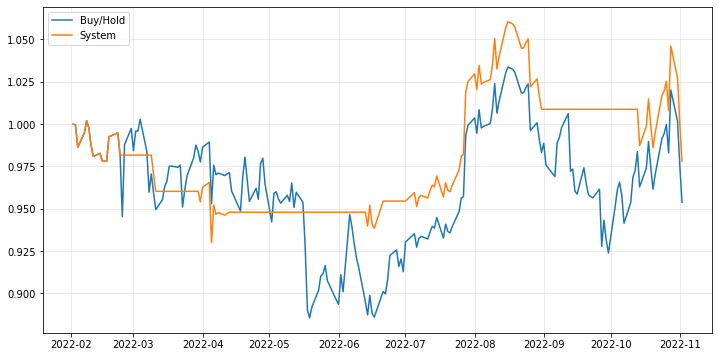

In [ ]:
plt.plot(np.exp(gld_KDP['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld_KDP['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

# Tabluating the results

## Total returns obtained by Buy and hold strategy

In [ ]:
Total_BnH_return = (0.13 * INVH_BnH_pct) + (0.29 * AES_BnH_pct) + (0.58 * KDP_BnH_pct)

Total_BnH_return

-0.015018481093166832

## Total returns obtained by Momentum Trading strategy

In [ ]:
Total_mt_return = (0.13 * INVH_mt_sys) + (0.29 * AES_mt_sys) + (0.58 * KDP_mt_sys)

Total_mt_return

-0.02496759028897376

##Portfolio of S&P 500

In [ ]:

tickers_list = ['^GSPC']

dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2022',end_date='11/02/2022',interval='1mo') for ticker in tickers_list}

Assuming 100% of the money is invested in the S&P 500

MPT Model

In [ ]:
from pandas.core.arrays import interval
import pandas_datareader as pdr
from datetime import datetime

myStock = '^GSPC'
gld_SnP = pdr.get_data_yahoo(myStock, start=datetime(2022, 1, 1), end=datetime(2022, 11, 2), interval = 'mo')

gld_SnP.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld_SnP = gld_SnP[['Open', 'High', 'Low', 'Close']]
gld_SnP

,Open,High,Low,Close
Date,,,,
2022-01-01,4778.140137,4818.620117,4222.620117,4515.549805
2022-02-01,4519.569824,4595.310059,4114.649902,4373.939941
2022-03-01,4363.140137,4637.299805,4157.870117,4530.410156
2022-04-01,4540.319824,4593.450195,4124.279785,4131.930176
2022-05-01,4130.609863,4307.660156,3810.320068,4132.149902
2022-06-01,4149.779785,4177.509766,3636.870117,3785.379883
2022-07-01,3781.000000,4140.149902,3721.560059,4130.290039
2022-08-01,4112.379883,4325.279785,3954.530029,3955.000000
2022-09-01,3936.729980,4119.279785,3584.129883,3585.620117


In [ ]:
invested_amount = 100000

jan_1_close = 4515.549805

nov_1_close = 4080.110107

number_of_shares = round(invested_amount / jan_1_close, 2)

number_of_shares

22.15

In [ ]:
SnP = round(number_of_shares * (nov_1_close - jan_1_close), 2)
print('$', SnP)

$ -9644.99


## Total returns obtained by S&P 500 strategy

In [ ]:
profit_SnP = (SnP/total_budget)*100
print('Portfolio Retuns Pct:', round(profit_SnP,2), '%')

Portfolio Retuns Pct: -9.64 %


## Comparisions and Analysis of Strategies

From the MPT model, we got the below stock portfolio:

Portfolio alloaction for IVNH is 13%

Portfolio alloaction for AES is 29%

Portfolio alloaction for KDP is 58%

We Initially invested 100k on January 1 and analyzed the returns across multiple strategies:


Buy & Hold Strategy:

If we had invested 100k using Buy and Hold Strategy, We would have ended up with $99985 by Nov 1, 2022. It is a loss of nearly 1.5%.

Momentum Trading Strategy:

If we had invested 100k using Momentum Trading Strategy, We would have ended up with $99975 by Nov 1, 2022. It is a loss of nealry 2.5%.

S&P 500:

If we had invested 100k using S&P 500 Strategy, We would have ended up with $999036 just by Nov 1, 2022. It is a loss of nearly 9.64%

Takeaway from the analysis:

Comparing the returns above, We would invest using Buy and Hold strategy for the period from Jan 1, 2022 till Nov 1, 2022 as it was giving us the minimal loss compared to other strategies

# Conclusion



* Learned how performance of a single stock in the portfolio will reflect on the whole from the start of the investment period. So understanding the allocation of stocks in portfolio is important for efficient calculation of risk and rewards of individual stocks.
*   Learnt how to interpret high risk and high reward would entail for the stock and determine the outcome of the portfolio
*   When calculating the risk, we experimented with the risk ceilings and size of the steps and learned that lower the bound size, the clearer it is to interpret the results as we are aiming for a more granular approach. So maximum risk we set and the bounds we give should be in cordination for effective interpretation of the results.

*   From the efficient frontier analysis, we observed that, after attaining a certain point in return, no matter how much we increase the risk, the return is still going to be the same. In our case, a return of 0.00067% is attained at a risk of 0.00015, and thereafter, no amount of risk will result in a higher return.


*   Based on efficient frontier, we have observed that INVH(Invitation Homes), AES(The AES Corporation) and KDP(Keurig Dr Pepper Inc.) are the 3 stocks that are better suited to be allocated in the portfolio.
*   When performing data transformation by adding moving averages to generate signals, we learned that adding shift() willl prevent data leakage
*  The best investment plan between January 1, 2022, and November 1, 2022, according to our research of Buy and Hold, Momentum Trading, and the S&P 500, is to use Buy and Hold for our top 3 stocks, INVH, AES, and KDP.

*   When returns are compared from Buy and Hold, Momentum trading and S&P 500, the most loses obtained for our combination of stocks is through S&P 500 strategy. The loss acquired is around 9.64%




#Group member's Contribution



1.   Data Prep and EDA - Brittany Love, Lekhana Shivashankar
2.   Optimization Model -  Brittany Love, Lekhana Shivashankar, Likhila Nimmagadda

3.   Momentum Trading - Sourya Peddina, Geetha Harshini Panchala
4.   Analysis - Likhila Nimmagadda



